In [17]:
#!pip install tf-models-official

In [1]:
import tensorflow as tf
import tensorflow_models as tfm

RuntimeError: jaxlib version 0.4.7 is newer than and incompatible with jax version 0.4.6. Please update your jax and/or jaxlib packages.

In [3]:
from tensorflow_models import vision

In [4]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, ConvLSTM2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

In [10]:
# https://stackoverflow.com/questions/63860100/reshape-a-4d-tensor-output-of-a-convolutional-layer-to-5d-tensor-to-be-fed-to-a

from tensorflow.keras.layers import Layer

NUM_FRAMES = 16
BATCH_SIZE = 8

class ReshapeLayer(Layer):
    def call(self,inputs):
        nshape = (BATCH_SIZE,NUM_FRAMES) + inputs.shape[1:]
        return tf.reshape(inputs,nshape)

In [15]:
# Define the input as a tensor with shape input_shape
filters = [64, 128, 256, 512]
strides = [1,   2,   1,   1]

SequenceLength = 10

input_shape=(480, 854, 3)
X_input = Input(input_shape)

# Zero-Padding
X = ZeroPadding2D((3, 3))(X_input)

# Stage 1
X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

for i in range(len(filters)):
  print(i)
  if (i > 0): 
    X = vision.layers.ResidualBlock(filters[i], strides[i], use_projection=True)(X)
    x = vision.layers.ResidualBlock(filters[i], strides[i], use_projection=True)(X)
  else:
    X = vision.layers.ResidualBlock(filters[i], strides[i], use_projection=False)(X)
    x = vision.layers.ResidualBlock(filters[i], strides[i], use_projection=False)(X)

# Need to move after ConvLSTM in final
X = Conv2D(filters=7, kernel_size=(1, 1), name='loc_map_layer')(X)

reshaped_input = ReshapeLayer()(X)

# Return sequence True will return all the sequence of images
# if set to false, it will only return the last image 
X = ConvLSTM2D(filters=7, kernel_size=(1, 1), name='convLSTMLayer', return_sequences=True)(reshaped_input)


model = Model(inputs=X_input, outputs=X, name='ResNet18')

0
1
2
3


In [16]:
model.summary()

Model: "ResNet18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 480, 854, 3)]     0         
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 486, 860, 3)      0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 240, 427, 64)      9472      
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 240, 427, 64)     256       
 n)                                                              
                                                                 
 activation_3 (Activation)   (None, 240, 427, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 119, 213, 64)     0  

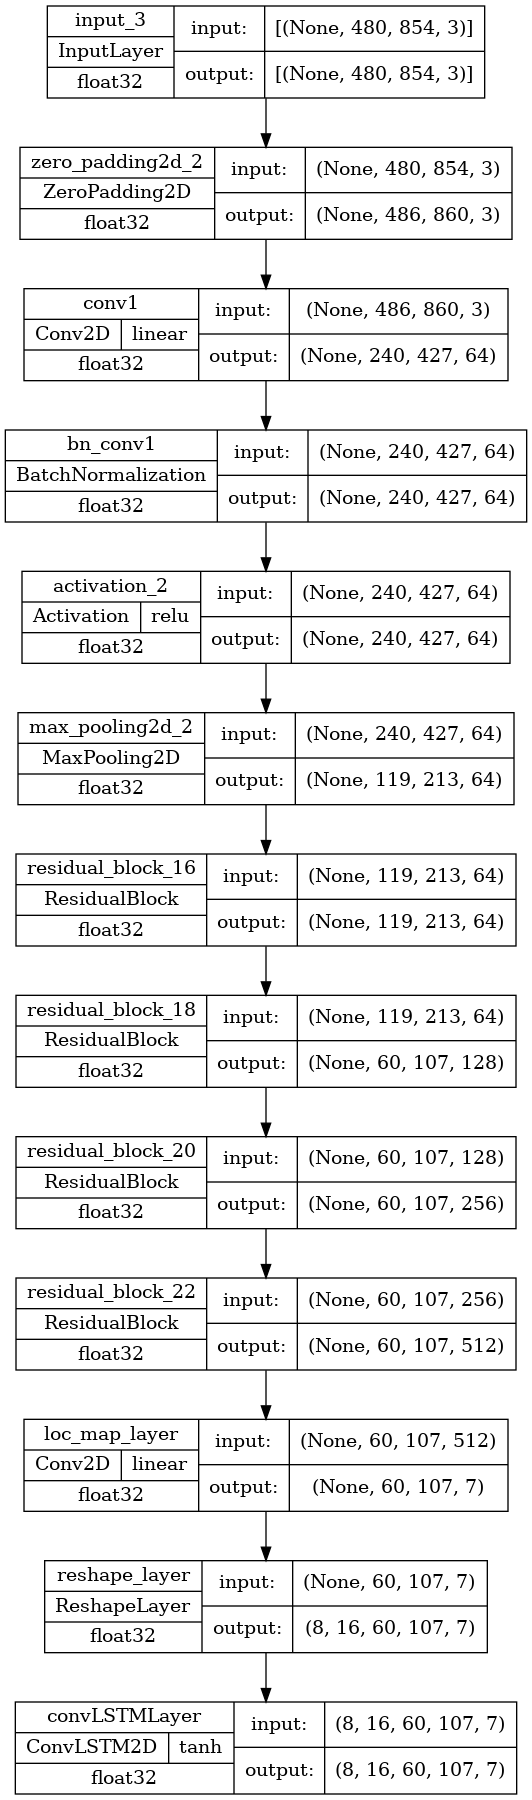

In [13]:
tf.keras.utils.plot_model(model,  
                          show_shapes=True, 
                          show_layer_activations=True, 
                          show_dtype=True,
                          show_layer_names=True )

Defaulting to user installation because normal site-packages is not writeable


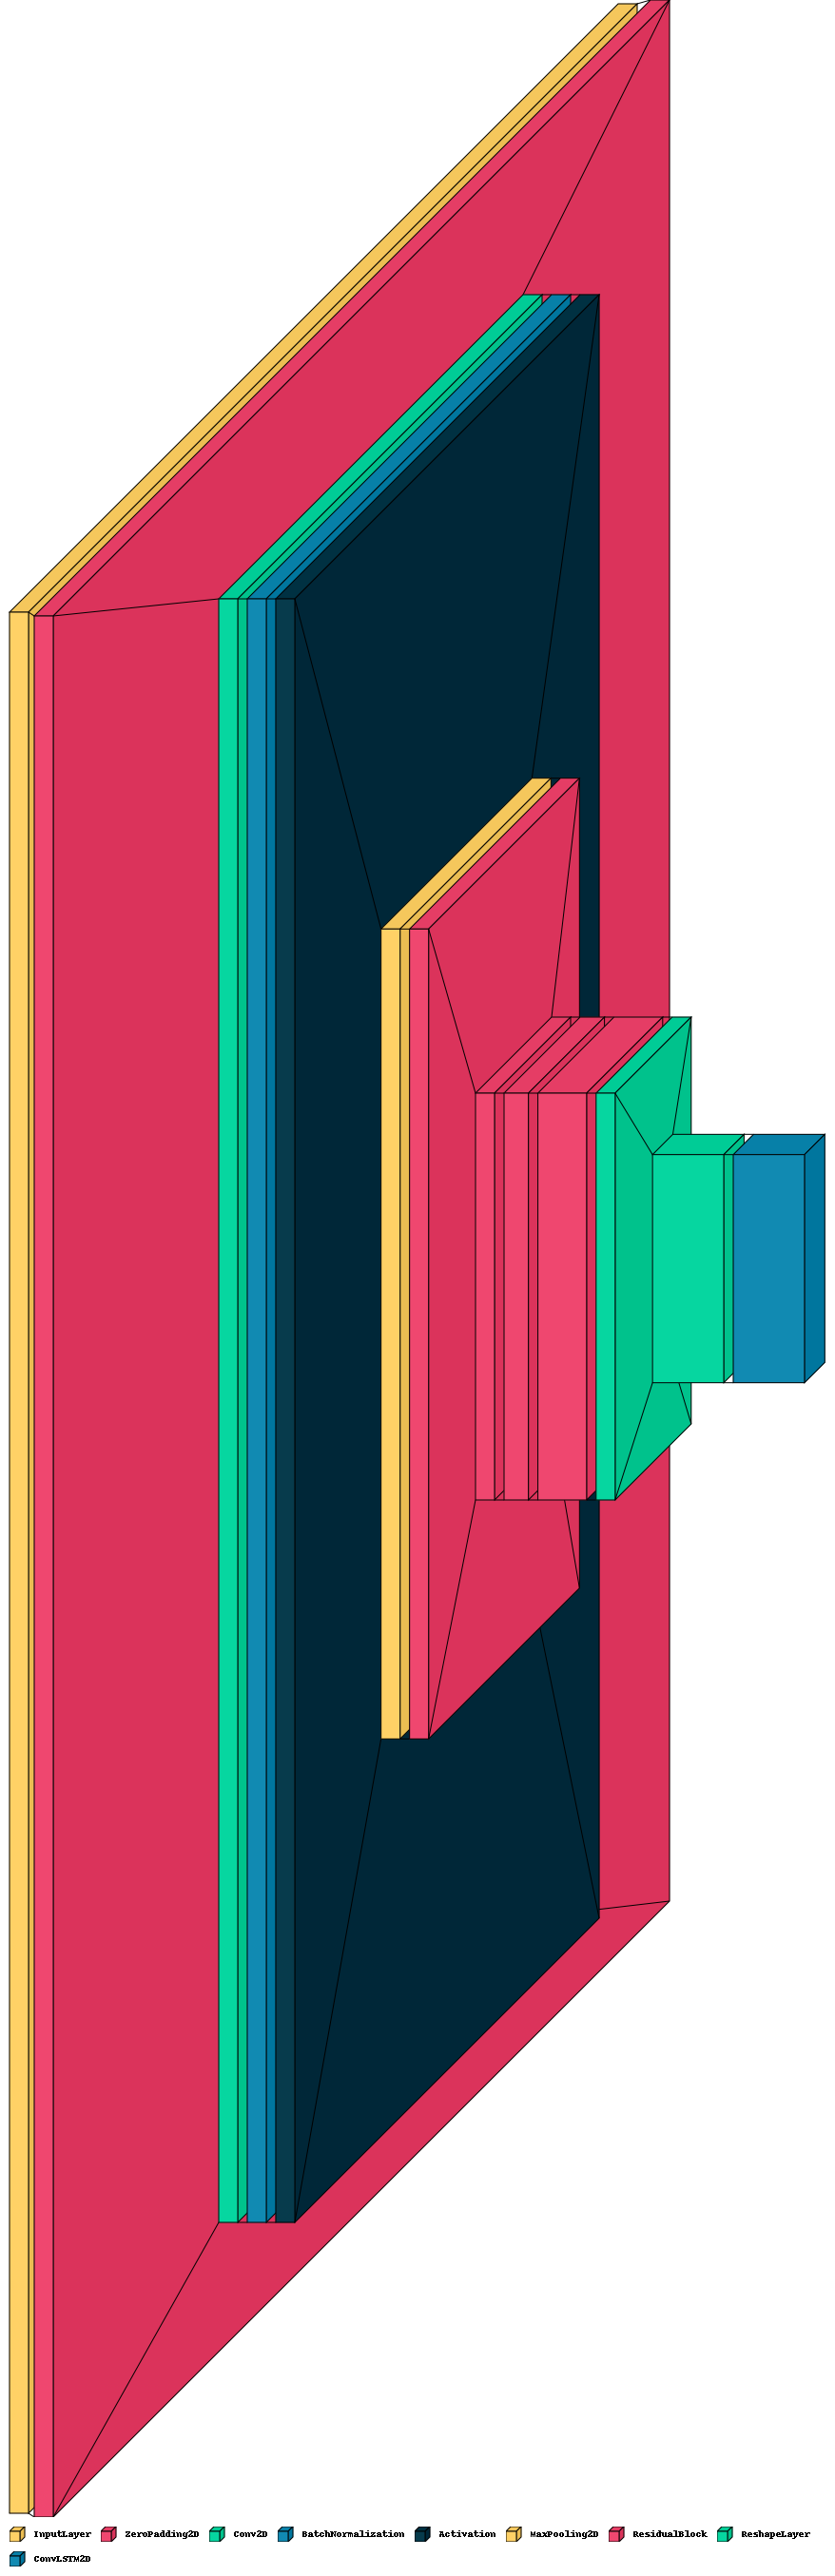

In [14]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model,legend=True, draw_volume=True)